# Modeling Cross Sections

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os
import importlib

print(tf.__version__)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.1.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
sns.set(font_scale=2)

In [2]:
import sys
# This allows us to import the nucml utilities
sys.path.append("..")

import nucml.exfor.data_utilities as exfor_utils
import nucml.exfor.plotting_utilities as exfor_plot
import nucml.endf.data_utilities as endf_utils
import nucml.plot.plotting_utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
importlib.reload(exfor_utils)
importlib.reload(exfor_plot)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
print("Finish importing scripts.")

NameError: name 'importlib' is not defined

# Creating Training, Validation, and Testing Datasets and Data Standarization 

In [6]:
# df = nuc_data.load_exfor(basic=True)
df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(log=True, basic=True, num=True, low_en=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_NaNRaw.csv
Reading data into dataframe...
 MODE: neutrons
 LOW ENERGY: True
 LOG: True
 BASIC: True
Data read into dataframe with shape:  (4184245, 10)
Dropping unnecessary features and one-hot encoding categorical columns...
Splitting dataset into training and testing...
Normalizing dataset...
Finished. Resulting dataset has shape  (4184245, 49) 
Training and Testing dataset shapes are (3765820, 48) and (418425, 48) respesctively.


# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [7]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}

chlorine_35_np = exfor_utils.load_exfor_samples(df, 17, 35, "MT_103", **kwargs)
uranium_235_nt = exfor_utils.load_exfor_samples(df, 92, 235, "MT_1", **kwargs)
uranium_233_nf = exfor_utils.load_exfor_samples(df, 92, 233, "MT_18", **kwargs)
uranium_233_nt = exfor_utils.load_exfor_samples(df, 92, 233, "MT_1", one_hot=True)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (40108, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 49)


In [8]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}
uranium = exfor_utils.load_exfor_element(df, 92, **kwargs)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (468123, 49)


# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

ENDF = MEV
EXFOR = EV

In [9]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":False, "scaler":scaler, "to_scale":to_scale}
new_cl_data = exfor_utils.load_exfor_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, **new_cl_data_kwargs)
new_cl_data.head()

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 49)
Expanded Dataset has shape:  (12, 49)


,Energy,Data,Target_Protons,Target_Neutrons,Target_Mass_Number,MT_1,MT_102,MT_16,MT_17,MT_2,MT_3,MT_4,MT_101,MT_103,MT_104,MT_41,MT_9000,MT_105,MT_32,MT_51,MT_33,MT_107,MT_24,MT_155,MT_158,MT_159,MT_108,MT_29,MT_1108,MT_113,MT_106,MT_22,MT_1003,MT_9001,MT_28,MT_111,MT_203,MT_2103,MT_112,MT_37,MT_161,MT_152,MT_153,MT_18,MT_160,Frame_L,Frame_C,Target_Flag_I,Target_Flag_N
0,6.383815,-1.779892,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.383815,-1.707744,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.401401,-1.583359,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,6.401401,-1.590067,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,6.411620,-1.350665,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [10]:
endf_cl = nuc_data.load_endf("Cl035", "MT103", mev_to_ev=True, mb_to_b=True, log=True)
endf_u  = nuc_data.load_endf("U233", "MT018", log=True)
endf_u_nonelastic  = nuc_data.load_endf("U233", "MT003", log=True, mb_to_b=False)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Cl035\endfb8.0\tables\xs\n-Cl035-MT103.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (8791, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT003.endfb8.0
Convering MeV to eV...
Finish reading ENDF data with shape:  (33329, 2)


# Reading ACE Energies

In [11]:
ace_u = ace_utils.get_energies("92233") * 1E6
ace_cl = ace_utils.get_energies("17035") * 1E6

# Optimization - Learning Rate

A gradually reducing learning rate with time performes better (jumping around). The `schedules.InverseTimeDecay` decreases rate hyperbolicallly to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 and so on.

# Compile and Fit Funciton - TensorBoard Logs

In [12]:
outputFolder = './output'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
# filepath=outputFolder+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath = outputFolder + "/model-{epoch:02d}-{loss:.2f}.hdf5"

In [25]:
FEATURES = len(x_train.columns)
BATCH_SIZE=150
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

In [51]:
def get_optimizer(lr_schedule):
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5), # val_loss
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1,
                                           save_best_only=False, save_weights_only=False,
                                           save_frequency=5),
        tf.keras.callbacks.TensorBoard(logdir/name)]


def compile_and_fit(model, name, x_train, y_train, x_test, y_test, BATCH_SIZE=120, max_epochs=5, DECAY_EPOCHS=10):
    STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=STEPS_PER_EPOCH*DECAY_EPOCHS,
        decay_rate=1, staircase=False)
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()
    
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=(x_test, y_test),
        callbacks=get_callbacks(name),
        verbose=1)   
    return history

In [52]:
# cpu_strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
single_gpu_strategy =  tf.distribute.OneDeviceStrategy(device="/GPU:0")
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Create a tf.data.Dataset Generator

The larger the `BATCH_SIZE`, the more efficient TensorFlow operates. 

In [53]:
# def tf_dataset_gen(x, y, xt, yt, BATCH_SIZE, gpu=False, strategy=None, cache=False):
#     N_TRAIN = len(x_train)
#     N_VALIDATION = len(x_test)
#     if gpu == True:
#         BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
#         print("GPU: ON")
        
#     train_dataset = tf.data.Dataset.from_tensor_slices((x.values, y.values)).cache().repeat().shuffle(N_TRAIN).batch(BATCH_SIZE)
#     test_dataset = tf.data.Dataset.from_tensor_slices((xt.values, yt.values)).batch(BATCH_SIZE)
    
#     STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
#     STEPS_PER_EPOCH_VAL = N_VALIDATION//BATCH_SIZE
#     print("BATCH SIZE PER REPLICA: ", int(BATCH_SIZE / strategy.num_replicas_in_sync))
#     print("STEPS PER EPOCH: {} \nSTEPS PER EPOCH VAL: {}".format(STEPS_PER_EPOCH, STEPS_PER_EPOCH_VAL))
#     return train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE

# BATCH_SIZE_PER_REPLICA = 64

# train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, BATCH_SIZE_GPU = tf_dataset_gen(
#     x_train, y_train, x_test, y_test, BATCH_SIZE_PER_REPLICA, gpu=True, strategy=strategy)

# Training Models

In [54]:
size_histories = {}

In [63]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(32, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(64, activation='elu'),
                                      layers.Dense(64, activation='elu'),
                                      layers.Dense(64, activation='elu'),
                                      layers.Dense(32, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_sGPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_sGPU', 
                                                  x_train, y_train, x_test, y_test, 
                                                  BATCH_SIZE=120, max_epochs=25, DECAY_EPOCHS=10)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                1568      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 14,113
Trainable params: 14,113
Non-trainable params: 0
__________________________________________________

In [70]:
# %%time
# with strategy.scope():
#     tiny_model = tf.keras.Sequential([layers.Dense(32, activation='elu', input_shape=(FEATURES,)), 
#                                       layers.Dense(64, activation='elu'),
#                                       layers.Dense(64, activation='elu'),
#                                       layers.Dense(64, activation='elu'),
#                                       layers.Dense(32, activation='elu'),
#                                       layers.Dense(1)])
#     size_histories['Tiny_mGPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_mGPU', 
#                                                   x_train, y_train, x_test, y_test, 
#                                                   BATCH_SIZE=120*2, max_epochs=5, DECAY_EPOCHS=10)

In [59]:
def plot_acc_loss(history):
    epochs = history.history.epoch
    train_acc = history.history.history["mse"]
    val_acc = history.history.history["val_mse"]

    train_loss = history.history.history["loss"]
    val_loss = history.history.history["val_loss"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    # fig.suptitle('Horizontally stacked subplots')
    ax1.plot(epochs, train_acc, label="Training Accuracy")
    ax1.plot(epochs, val_acc, label="Validation Accuracy")
    ax1.legend()

    ax2.plot(epochs, train_loss, label="Training Loss")
    ax2.plot(epochs, val_loss, label="Validation Loss")
    ax2.legend()

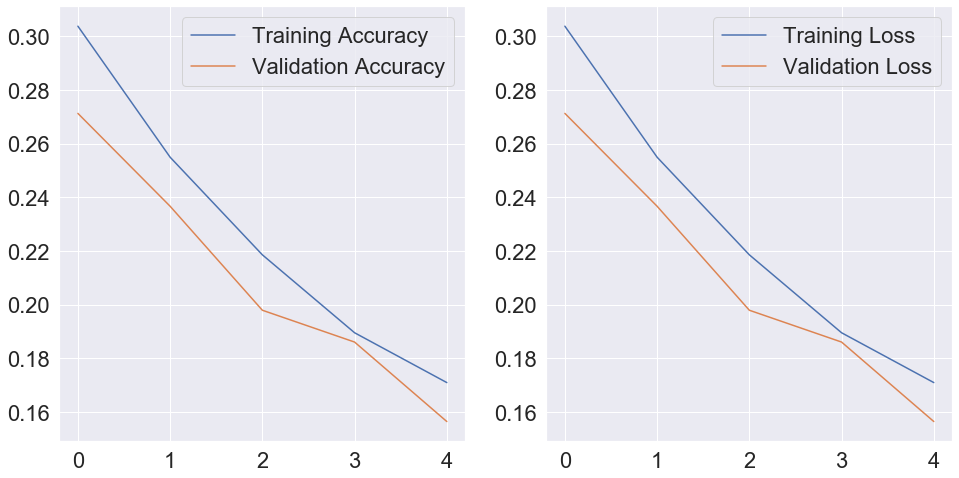

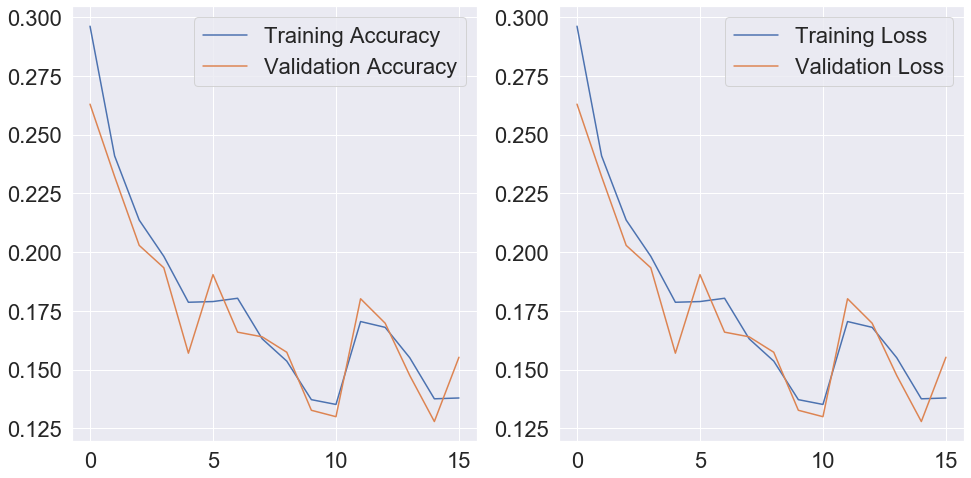

In [65]:
plot_acc_loss(size_histories['Tiny_mGPU'].model)

plot_acc_loss(size_histories['Tiny_sGPU'].model)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


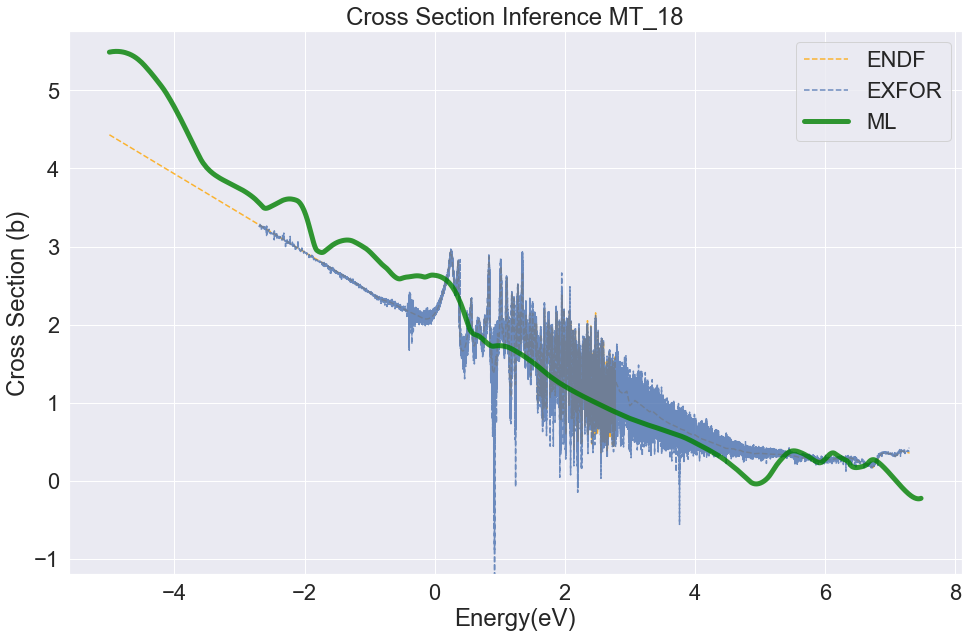

EXFOR VS ML: Original Data
The MSE is:  0.10821187627056549
The MAE is:  0.2628923312660117
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


..\nucml\exfor\data_utilities.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_interest["Data"] = np.nan


In [62]:
u_kwargs =  {"Z":92, "A":233, "MT":"MT_18", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_u), "log":True, "focus":False, 
             "error":True, "show":True}
results_u = exfor_utils.predicting_nuclear_xs(df, clf=size_histories['Tiny_mGPU'].model, endf=endf_u, **u_kwargs)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


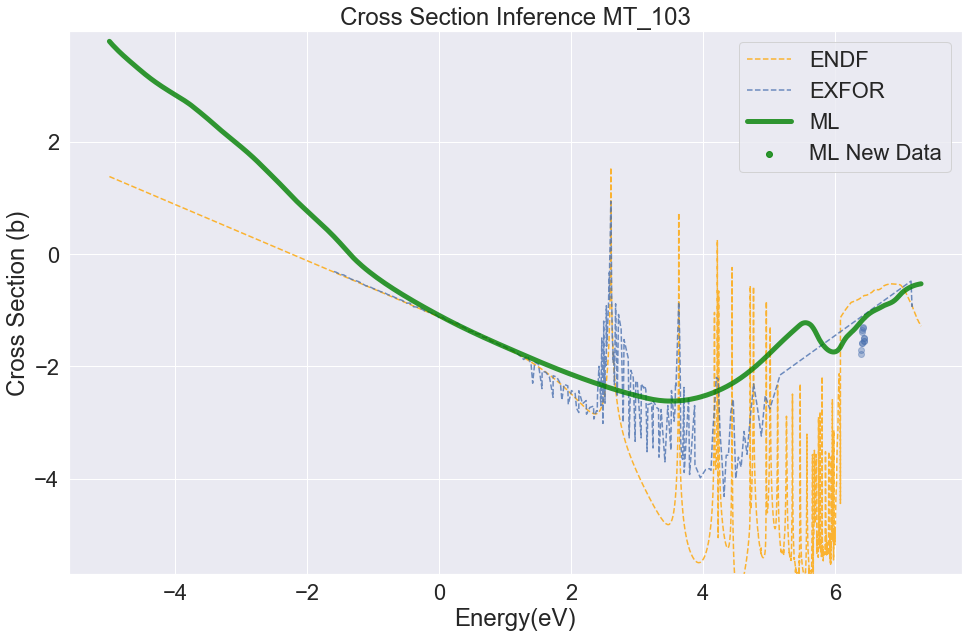

EXFOR VS ML: Original Data
The MSE is:  0.7456291370431043
The MAE is:  0.5923567589148546
EXFOR VS ML: New Data
The MSE is:  1606.6987060324388
The MAE is:  40.083378087358724
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888


..\nucml\exfor\data_utilities.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_interest["Data"] = np.nan
..\nucml\exfor\data_utilities.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_interest["Data"] = np.nan


In [61]:
cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_cl), "log":True, "focus":False, "error":True, "show":True}
results_cl = exfor_utils.predicting_nuclear_xs(df, clf=size_histories['Tiny_mGPU'].model, new_data=new_cl_data, endf=endf_cl, **cl_kwargs)

In [66]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(122, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(522, activation='elu'),
                                      layers.Dense(522, activation='elu'),
                                      layers.Dense(522, activation='elu'),
                                      layers.Dense(122, activation='elu'),
                                      layers.Dense(1)])

    size_histories['Medium_sGPU'] = compile_and_fit(tiny_model, 'sizes/Medium_sGPU', 
                                                  x_train, y_train, x_test, y_test, 
                                                  BATCH_SIZE=120*2, max_epochs=50, DECAY_EPOCHS=10)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 122)               5978      
_________________________________________________________________
dense_39 (Dense)             (None, 522)               64206     
_________________________________________________________________
dense_40 (Dense)             (None, 522)               273006    
_________________________________________________________________
dense_41 (Dense)             (None, 522)               273006    
_________________________________________________________________
dense_42 (Dense)             (None, 122)               63806     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 123       
Total params: 680,125
Trainable params: 680,125
Non-trainable params: 0
________________________________________________

In [71]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(1)])
    
    size_histories['Big_sGPU'] = compile_and_fit(tiny_model, 'sizes/Big_sGPU', 
                                                  x_train, y_train, x_test, y_test, 
                                                  BATCH_SIZE=120*2, max_epochs=25, DECAY_EPOCHS=10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 112)               5488      
_________________________________________________________________
dense_77 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_78 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_79 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_80 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_81 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_82 (Dense)             (None, 112)             

In [72]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='relu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(1)])
    
    size_histories['Big_sGPUm'] = compile_and_fit(tiny_model, 'sizes/Big_sGPUm', 
                                                  x_train, y_train, x_test, y_test, 
                                                  BATCH_SIZE=120*2, max_epochs=25, DECAY_EPOCHS=10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 112)               5488      
_________________________________________________________________
dense_93 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_94 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_95 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_96 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_97 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_98 (Dense)             (None, 112)             

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


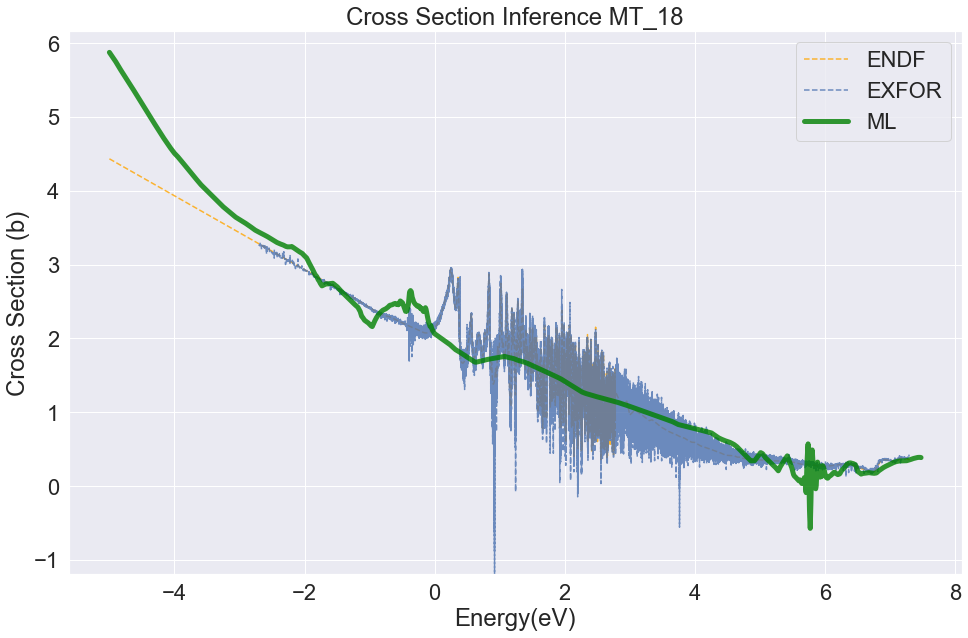

EXFOR VS ML: Original Data
The MSE is:  0.08994825761650342
The MAE is:  0.22930197321309653
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


..\nucml\exfor\data_utilities.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_interest["Data"] = np.nan


In [73]:
u_kwargs =  {"Z":92, "A":233, "MT":"MT_18", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_u), "log":True, "focus":False, 
             "error":True, "show":True}
results_u = exfor_utils.predicting_nuclear_xs(df, clf=size_histories['Big_sGPUm'].model, endf=endf_u, **u_kwargs)

In [67]:
# %%time
# with gpu_strategy.scope():
#     tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
#                                       layers.Dense(1)])
#     size_histories['Tiny_GPU_500'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500', 
#                                                  train_dataset_gpu, test_dataset_gpu, 
#                                                       STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=500)

In [42]:
# %%time
# with gpu_strategy.scope():
#     tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
#                                       layers.Dense(1)])
#     size_histories['Tiny_GPU_15000'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500', 
#                                                  train_dataset_gpu, test_dataset_gpu, 
#                                                       STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

In [74]:
%%time
dropout_frac = 0.1

with single_gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(dropout_frac),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(dropout_frac),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(dropout_frac),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(dropout_frac),
        layers.Dense(1)
    ])
    
    size_histories['Big_Drop_Reg'] = compile_and_fit(combined_model, 'sizes/Big_Drop_Reg', 
                                                  x_train, y_train, x_test, y_test, 
                                                  BATCH_SIZE=120, max_epochs=25, DECAY_EPOCHS=10)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 512)               25088     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)             

In [43]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                784       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [46]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp112'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp112', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 112)               5488      
_________________________________________________________________
dense_16 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_17 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_18 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_19 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_20 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_21 (Dense)             (None, 112)              

In [48]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='relu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp_relu'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp_relu', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 112)               5488      
_________________________________________________________________
dense_32 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_33 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_34 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_35 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_36 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_37 (Dense)             (None, 112)              

In [104]:
# plt.figure(figsize=(15,10))
# plotter = tfdocs.plots.HistoryPlotter(metric='mae', smoothing_std=5)
# plotter.plot(size_histories)
# plt.ylim()
# plt.ylabel('MAE [MeV]')

In [50]:
%%time
with single_gpu_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['Medium_GPU'] = compile_and_fit(medium_model, 'sizes/Medium_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                3136      
_________________________________________________________________
dense_48 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:12.1501,  mae:0.8857,  mse:12.1501,  val_loss:1.7294,  val_mae:0.6091,  val_mse:1.7294,  
....................................................................................................
Epoch: 100, loss:5.1973,  mae:0.6206,  ms

In [51]:
%%time
with single_gpu_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['Large_GPU'] = compile_and_fit(large_model, 'sizes/Large_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 512)               25088     
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_54 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 513       
Total params: 813,569
Trainable params: 813,569
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:12.8413,  mae:1.3320,  mse:12.8413,  val_loss:1.6885,  val_mae:0.8537,  val_mse:1.6885,  
........

In [53]:
# plt.figure(figsize=(15,10))
# plotter.plot(size_histories)
# a = plt.xscale('log')
# plt.xlim([5, max(plt.xlim())])
# # plt.ylim([0.5, 0.7])
# plt.yscale('log')
# plt.xlabel("Epochs [Log Scale]")

# Adding Regularization

As we know from Occam's Razor Principle the simplest one is the most likeley to be correct (the one with least amount of assumptions). Similar for neural networks, there will always be multiple models and therefore weights that can explain data. A simple model in this context is a model where the distribution of parameter values has less entropy. A common way to mitigate overfitting is to put constraints on the complexity of the NN by forcing weights to take small values which makes the distribution of such values more regular (weight regularization). This can be done by adding to the loss functionof the network a cost associated with having large weights. This costs can be:
- L1 Regularization: cost added proportional to the absolute value of the weights coefficients (L1 Norm). It pushes weights towards exactly 0 encouraging sparsity.
- L2 Regularization: proportional to the square of the value of the weights coefficients (L2 Norm). It is also called weight decay in NN context. It penalizes weight parameters without making them sparse since the weights go to 0 but are not 0. More common of the two. 

The `regularizers.l2(VALUE)` will make that every coefficient in the weight matrix of the layer will add VALUE * $weight_coefficients_value**2$ to the total loss of the network. In binary classification problems we monitor binary crossentropy since it doesnt have this regularization component mixed in.

Check if l2 is better than large at overfitting (same parameters)?

Dropout one of the most effective and most commonly used for NN. It is based on the fact that individual nodes in the N cannot rely on the output of the otherse, each node must output features that are useful on their own. The drooput layer randomly droppes out (set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of features that are zeroed out (between 0.2 to 0.5 usually). 

In [54]:
regularizer_histories = {}
# regularizer_histories['Tiny_GPU_1000'] = size_histories['Tiny_GPU_1000']

In [55]:
%%time
with single_gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               25088     
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_59 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 513       
Total params: 813,569
Trainable params: 813,569
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:12.3083,  mae:1.1600,  mse:10.6891,  val_loss:4.1694,  val_mae:1.2044,  val_mse:2.5574,  
........

In [57]:
%%time
with single_gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 512)               25088     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)             

In [58]:
%%time
with single_gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 512)               25088     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 512)             

In [59]:
%%time
with single_gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined_1000'] = compile_and_fit(combined_model, 'regularizers/combined_1000', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 1000)              49000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 1000)            

In [61]:
# plt.figure(figsize=(15,10))
# plotter.plot(regularizer_histories)
# a = plt.xscale('log')
# plt.xlim([2, max(plt.xlim())])
# # plt.ylim([0.5, 0.7])
# plt.yscale('log')
# plt.xlabel("Epochs [Log Scale]")

In [121]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout_3'] = compile_and_fit(dropout_model, 'regularizers/dropout_3', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)             

In [62]:
# hist = pd.DataFrame(regularizer_histories['l2'].history)
# hist['epoch'] = regularizer_histories['l2'].epoch
# hist.tail()

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.